using pcolormesh to plot an x-z cross section of the cloudsat radar reflectivity


## Data layout

The GEOPROF-GRANULE file contains two datasets with shape (37082, 125).  The first is Height, which is
the height in meters above a reference surface, ranging from -5000 meters to +25,000 meters. The second is Radar_Reflectivity, which is the Z
value at that height.  The two dimensions are:

* nray = 37082, which is the number of times the radar pulsed during an orbit

* nbin = 125, which is the number of height bins the reflectivity is placed into.  The heights of each
  sampled return will vary slightly from pulse to pulse.

##  Read in the height and reflectivity fields

In [30]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
from pyhdf.SD import SD, SDC

z_file= list(a301.data_dir.glob('*GEOPROF_GRANULE*hdf'))[0]
meters2km=1.e3

lats,lons,date_times,prof_times,dem_elevation=get_geo(z_file)
the_file = SD(str(z_file), SDC.READ)
radar_var = the_file.select('Radar_Reflectivity')
attrs = radar_var.attributes()
radar_reflectivity_raw = radar_var.get()
scale = attrs['factor']
missing_val = attrs['missing']
height = the_file.select('Height').get()
print(the_file.datasets())
the_file.end()

{'Height': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37080, 125), 22, 0), 'CPR_Cloud_mask': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37080, 125), 20, 1), 'Gaseous_Attenuation': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37080, 125), 22, 2), 'Radar_Reflectivity': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37080, 125), 22, 3)}


## Make a masked array of the reflectivity so that pcolormesh will plot it


In [31]:
hit=np.equal(radar_reflectivity_raw, missing_val)
#
# convert from int16 to float32
#
zvals=radar_reflectivity_raw.astype('float32')
zvals[hit]=np.nan
zvals = zvals/scale
zvals=ma.masked_invalid(zvals)

## Subset the segment to the  3 minutes containing the storm


In [32]:
first_time=date_times[0]
last_time=date_times[-1]

print(f'orbit start: {first_time}')
print(f'orbit end: {last_time}')
start_hour=3
start_minute=58
storm_start=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
#
# get 3 minutes of data from the storm_start
#
minutes=3
storm_stop=storm_start + dt.timedelta(minutes=minutes)
print(f'storm start: {storm_start}')
print(f'storm start: {storm_stop}')
#
# get the part of the data that falls between the start and stop times.
#
hit_segment = np.logical_and(date_times > storm_start,date_times < storm_stop)
# print(f'Hit Segment : {hit_segment}')
lats_segment = lats[hit_segment]
lons_segment=lons[hit_segment]
# print(prof_times)
prof_times=prof_times[hit_segment]
zvals_segment=zvals[hit_segment,:]
height_segment=height[hit_segment,:]
date_times=date_times[hit_segment]
# print(f'lons segment: {lons_segment}')

orbit start: 2010-09-15 02:25:11.533000+00:00
orbit end: 2010-09-15 04:04:04.173137+00:00
storm start: 2010-09-15 03:58:00+00:00
storm start: 2010-09-15 04:01:00+00:00


## convert time to distance by using pyproj to get the greatcircle distance between shots


In [33]:
great_circle=pyproj.Geod(ellps='WGS84')
distance=[0]
start=(lons_segment[0],lats_segment[0])
for index,the_lon in enumerate(lons_segment[1:]):
    azi12,azi21,step= great_circle.inv(lons_segment[index],lats_segment[index],
                                       the_lon,lats_segment[index+1])
    distance.append(distance[index] + step)
distance=np.array(distance)/meters2km

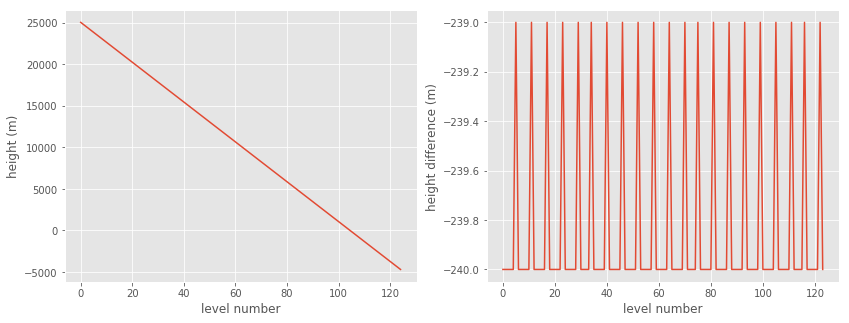

In [34]:
heights=height_segment[0,:]
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(right=1.2)
ax1.plot(heights)
ax2.plot(np.diff(heights))
ax1.set(xlabel='level number',ylabel='height (m)')
ax2.set(xlabel='level number', ylabel='height difference (m)');

#Spacing between radar height levels differs slightly 

## Assume that height same for every shot

* In reality, the bin heights depend on the details of the radar returns
* Historgram the heights into a uniform set of bins -- ignore that for this qualitative picture
* Convert the row and column numbers to heights (yaxis) vs. distance (xaxis).  
* Done by pcolormesh, which builds a mesh of the image and then samples it in uniform (distance, height) bins, sort of like pyresample.



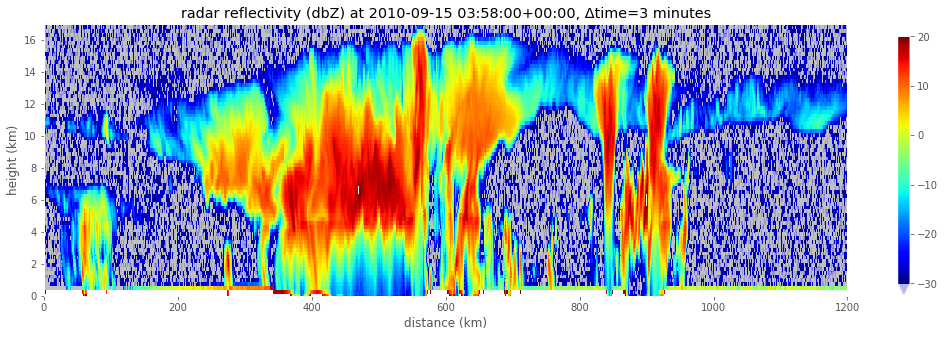

In [35]:
%matplotlib inline
plt.close('all')
fig,ax=plt.subplots(1,1,figsize=(18,5))

from matplotlib import cm
from matplotlib.colors import Normalize
vmin=-30
vmax=20
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap=cm.jet
cmap.set_over('w')
cmap.set_under('b',alpha=0.2)
cmap.set_bad('0.75') #75% grey

col=ax.pcolormesh(distance,height_segment[0,:]/meters2km,zvals_segment.T,cmap=cmap,
                  norm=the_norm)
ax.set(ylim=[0,17],xlim=(0,1200))
fig.colorbar(col,extend='both')
ax.set(xlabel='distance (km)',ylabel='height (km)',
       title=f'radar reflectivity (dbZ) at {storm_start}, Δtime={minutes} minutes');